In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

1. Load Data and calculate distance

In [16]:
interlayer_v_2019_path = r"E:\Project\Academic\虚实网络\Data\Table\interlayer_v_2019_xy.csv"
interlayer_v_2020_path = r"E:\Project\Academic\虚实网络\Data\Table\interlayer_v_2020_xy.csv"
interlayer_v_2023_path = r"E:\Project\Academic\虚实网络\Data\Table\interlayer_v_2023_xy.csv"

# distance_dict: {node1: {node2: distance}}
df_distance = pd.read_csv(interlayer_v_2019_path)
df_distance['distance'] = np.sqrt((df_distance['POINT_X_x'] - df_distance['POINT_X_y'])**2 + 
                                  (df_distance['POINT_Y_x'] - df_distance['POINT_Y_y'])**2)
distance_dict = (df_distance.groupby('NodeID1').apply(lambda g: dict(zip(g['NodeID2'], g['distance']))).to_dict())

# interlayer_v_dict: {time: pd}
interlayer_v_dict = {time: pd.concat([pd.read_csv(path), df_distance['distance']], axis=1) 
                     for time, path in zip(["2019", "2020", "2023"], 
    [interlayer_v_2019_path, interlayer_v_2020_path, interlayer_v_2023_path])}

C:\Users\a\AppData\Local\Temp\ipykernel_29828\1237364691.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  distance_dict = (df_distance.groupby('NodeID1').apply(lambda g: dict(zip(g['NodeID2'], g['distance']))).to_dict())


In [77]:
interlayer_v_dict[time].head()

,NodeID1,NodeID2,Weight,id_x,name_x,city_id_Amap_x,POINT_X_x,POINT_Y_x,id_y,name_y,city_id_Amap_y,POINT_X_y,POINT_Y_y,distance
0,1,1,0.393160,1,北京市,110000,116.412284,40.185543,1,北京市,110000,116.412284,40.185543,0.000000
1,1,2,0.478971,1,北京市,110000,116.412284,40.185543,2,天津市,120000,117.334038,39.293426,1.282772
2,1,3,0.233937,1,北京市,110000,116.412284,40.185543,3,石家庄市,130100,114.439869,38.131270,2.847887
3,1,4,0.418161,1,北京市,110000,116.412284,40.185543,4,唐山市,130200,118.335626,39.721554,1.978517
4,1,5,0.304432,1,北京市,110000,116.412284,40.185543,5,秦皇岛市,130300,119.185043,40.087971,2.774475


Draw

C:\Users\a\AppData\Local\Temp\ipykernel_29828\4116065038.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = interlayer_v_dict[time][interlayer_v_dict[time]['Weight'] != 0][interlayer_v_dict[time]['NodeID1'] != interlayer_v_dict[time]['NodeID2']]
C:\Users\a\AppData\Local\Temp\ipykernel_29828\4116065038.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = interlayer_v_dict[time][interlayer_v_dict[time]['Weight'] != 0][interlayer_v_dict[time]['NodeID1'] != interlayer_v_dict[time]['NodeID2']]
C:\Users\a\AppData\Local\Temp\ipykernel_29828\4116065038.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = interlayer_v_dict[time][interlayer_v_dict[time]['Weight'] != 0][interlayer_v_dict[time]['NodeID1'] != interlayer_v_dict[time]['NodeID2']]


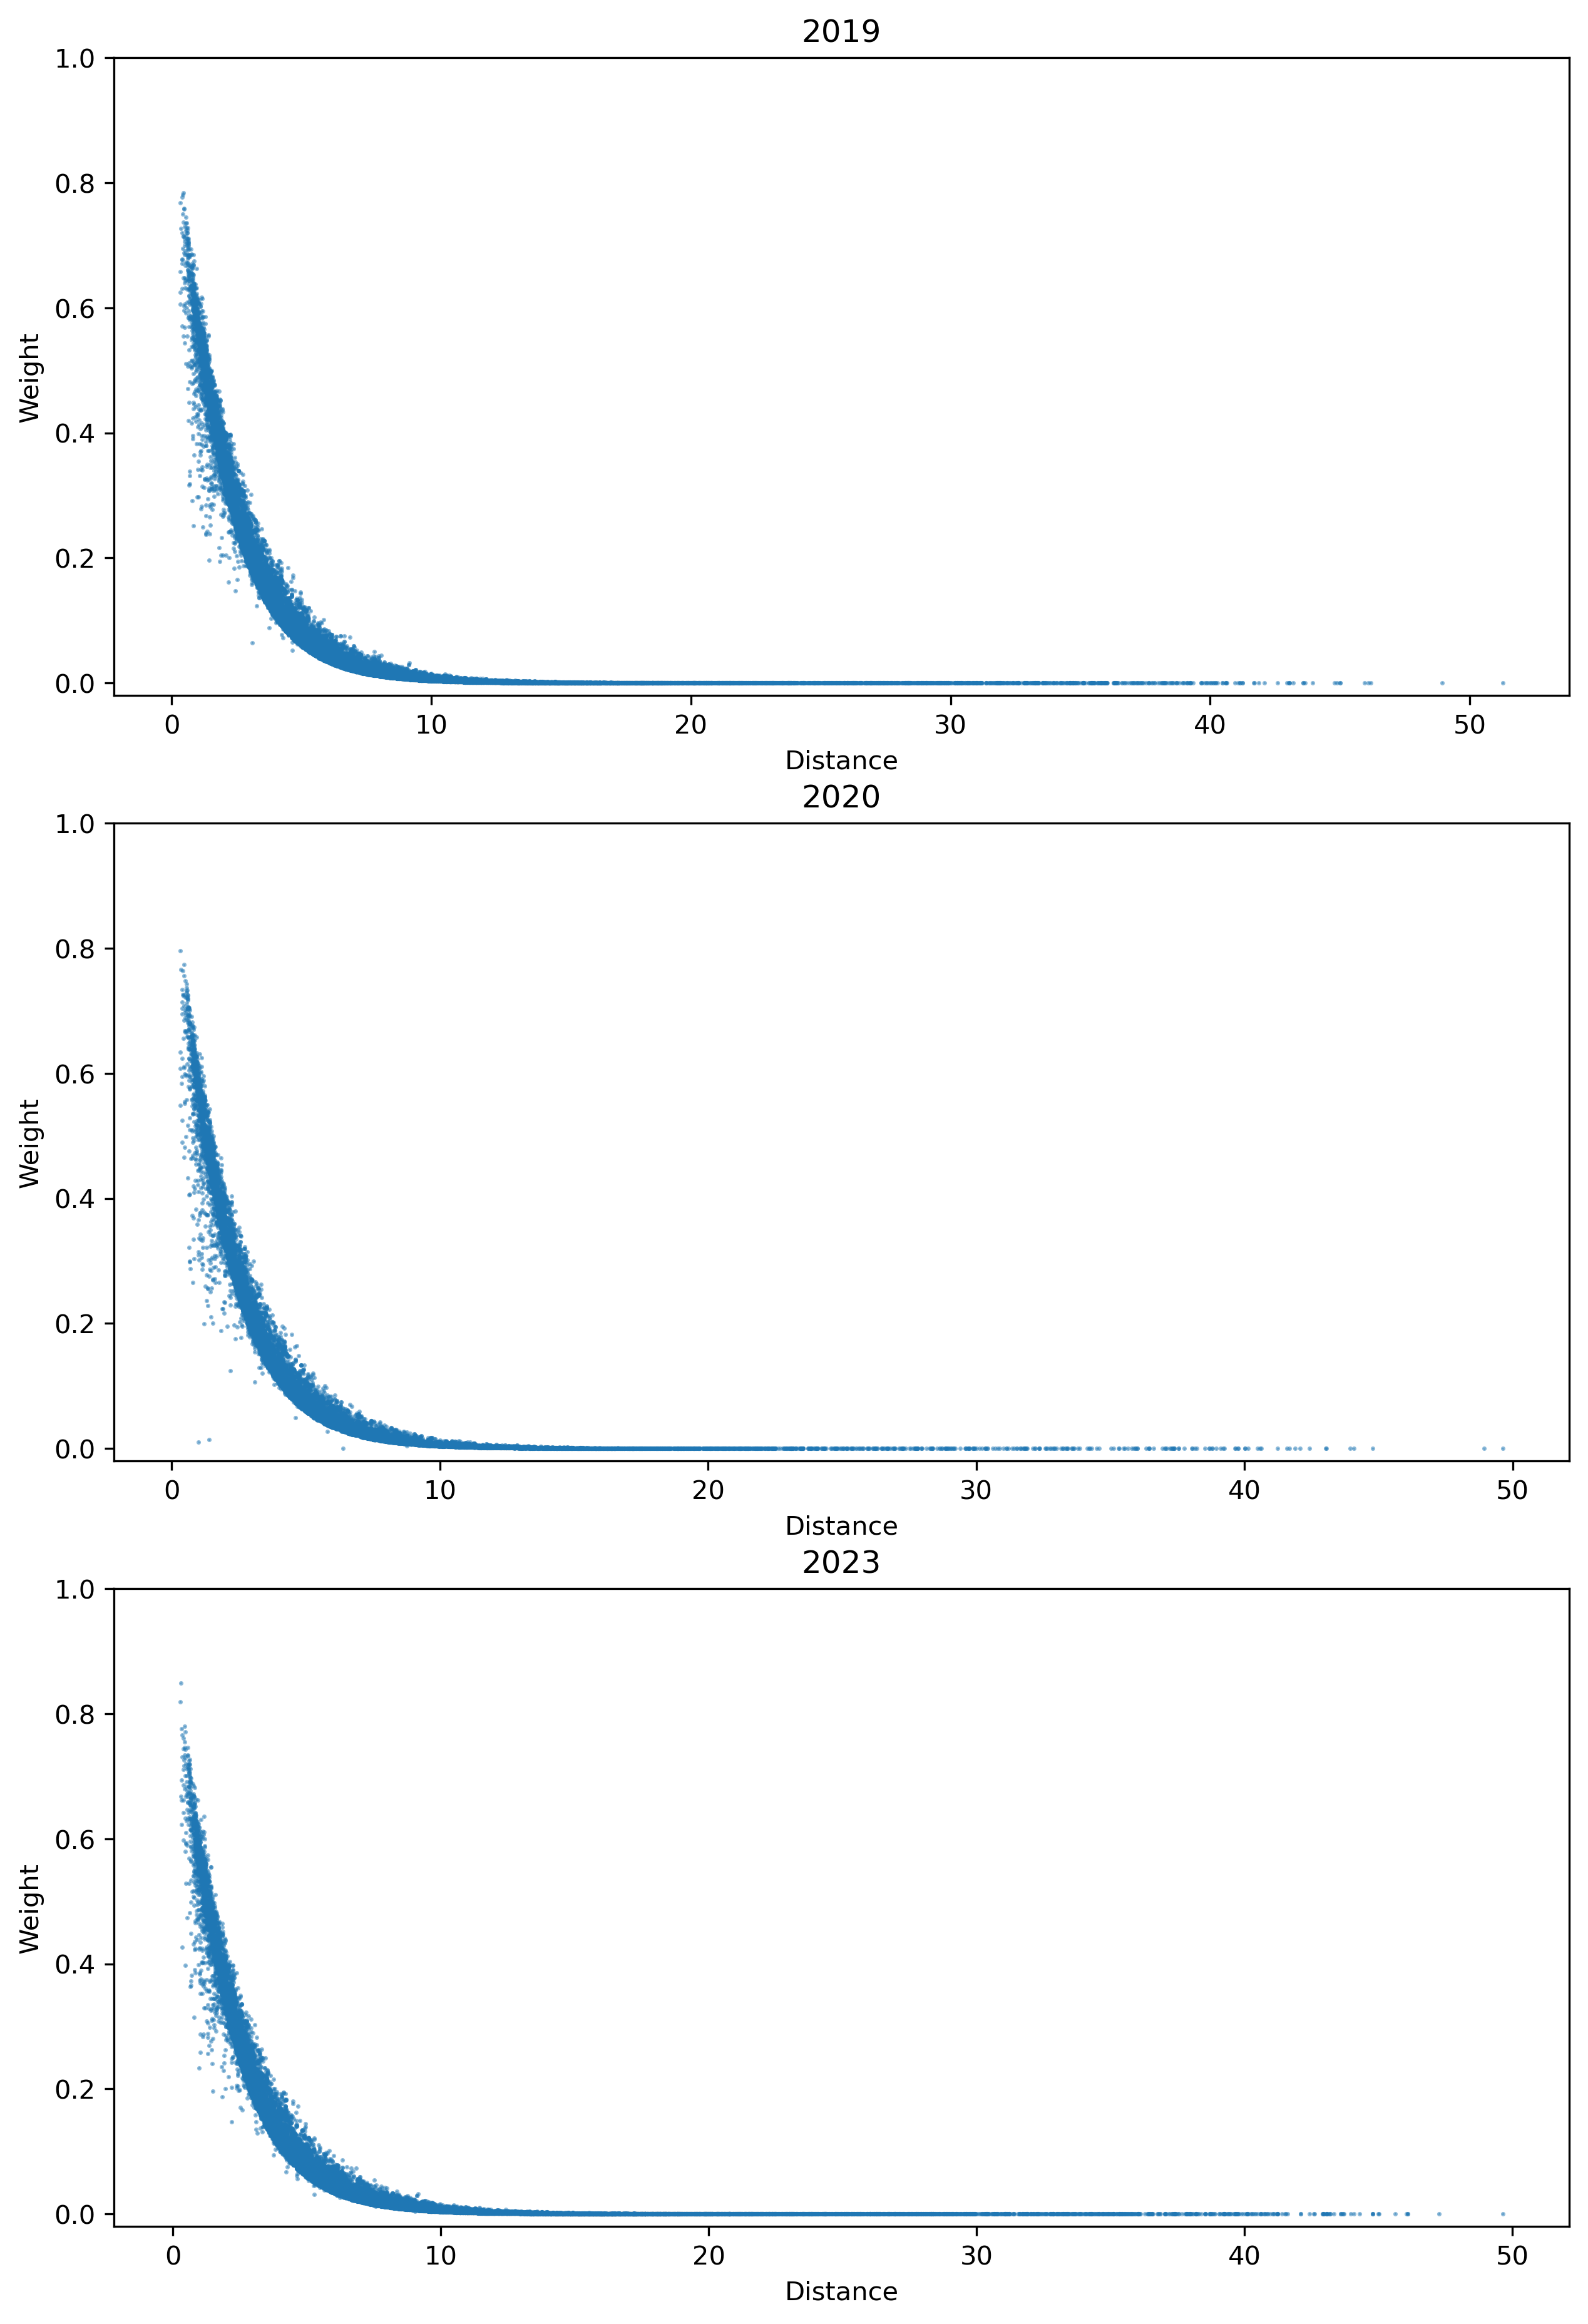

In [84]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15), dpi=300)

for time, n in zip(["2019", "2020", "2023"], [0,1,2]):
    filtered_df = interlayer_v_dict[time][interlayer_v_dict[time]['Weight'] != 0][interlayer_v_dict[time]['NodeID1'] != interlayer_v_dict[time]['NodeID2']]
    axes[n].scatter(filtered_df['distance'], filtered_df['Weight'], s = 0.5, alpha=0.5)

    axes[n].set_ylim(-0.02, 1)
    axes[n].set_xlabel('Distance')
    axes[n].set_ylabel('Weight')
    axes[n].set_title(time)

2. Aggregate City

In [87]:
# interlayer_v_mergedbynode_dict: {time: merged_pd}
interlayer_v_mergedbynode_dict = {}

for time in ["2019", "2020", "2023"]:
    weight_out_df = interlayer_v_dict[time].groupby('NodeID1')['Weight'].sum().reset_index()
    weight_out_df.columns = ['NodeID', 'weight_out']

    weight_in_df = interlayer_v_dict[time].groupby('NodeID2')['Weight'].sum().reset_index()
    weight_in_df.columns = ['NodeID', 'weight_in']  # 将 NodeID2 列名重命名为 NodeID，并生成 weight2

    merged_df = pd.merge(weight_out_df, weight_in_df, on='NodeID', how='outer')
    merged_df.fillna(0, inplace=True)

    df_0 = pd.merge(merged_df, interlayer_v_dict[time], left_on='NodeID', right_on='NodeID1', how='left')
    merged_df['POINT_X'] = df_0['POINT_X_x']
    merged_df['POINT_Y'] = df_0['POINT_Y_x']

    interlayer_v_mergedbynode_dict[time] = merged_df

    merged_df.to_csv(f"data_out\interlayer_v_mergedbynode_{time}.csv", index=False)